In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import re
import nltk
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import WordNetLemmatizer
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import torchtext
from torchtext import data
import torch.nn.functional as F
from torchtext.vocab import Vectors
from sklearn.model_selection import train_test_split

# The other libraries needed for optimised hyper-parameter tuning

# from hyperopt import hp, Trials, fmin, tpe, STATUS_OK
# from ignite.engine import Engine, Events
# from torch.utils.data import Dataset, DataLoader
# from nltk.stem import WordNetLemmatizer
# from ignite.metrics import Accuracy, Precision, Recall, ConfusionMatrix, Loss
# from ignite.contrib.handlers import ProgressBar
# from ignite.handlers import EarlyStopping, ModelCheckpoint

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\deepika\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Loading the required varibales and creating some varibales to make the results reproducible
nlp = spacy.load("en_core_web_sm")
PUNCT_TO_REMOVE = string.punctuation
lemmatizer = WordNetLemmatizer()

# First checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)

Device:  cuda


In [3]:
# reading the dataset
df = pd.read_csv('smsspamcollection.txt', sep='\t', names=['category', 'text'])

print('Shape before removing duplicates: ', df.shape)
df = df.drop_duplicates()
print('Shape after removing duplicates: ', df.shape)
df = df.dropna()
print('Shape after removing null values: ', df.shape)

Shape before removing duplicates:  (5572, 2)
Shape after removing duplicates:  (5169, 2)
Shape after removing null values:  (5169, 2)


In [4]:
# Let's look at the summary statistics of the dataset
df.describe()

,category,text
count,5169,5169
unique,2,5169
top,ham,i felt so...not any conveying reason.. Ese he....
freq,4516,1


## Text preprocessing


In [5]:
# Lower casing the words
df['text'] = df['text'].str.lower()

# removing punctuation marks
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
df["text"] = df["text"].apply(lambda text: remove_punctuation(text))


# Removing stopwords
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOP_WORDS])
df["text"] = df["text"].apply(lambda text: remove_stopwords(text))

        
# Lemmatizing the text data
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
df["text"] = df["text"].apply(lambda text: lemmatize_words(text))

# to clean data
def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

df["text"] = normalise_text(df["text"])

In [6]:
# we can also remove frquent occurent and least frequent words
print('Shape of the preprossed dataset: ', df.shape)

df = df.drop_duplicates()
print('Shape after removing duplicates from the preprossed dataset: ', df.shape)
df = df[df['text'] != ""]
print('Shape after removing datapoints with empty text: ', df.shape)

Shape of the preprossed dataset:  (5169, 2)
Shape after removing duplicates from the preprossed dataset:  (5094, 2)
Shape after removing datapoints with empty text:  (5093, 2)


In [7]:
df.head()

,category,text
0,ham,jurong point crazy available bugis n great wor...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun early hor u c
4,ham,nah dont think go usf life


Note: We could use more steps in preprocessing such as:
1. We could remove the most frequent and least frequent words
2. We could put all the text through a spelling checker library
3. We could remove numbers and HTML tags from the dataset, if any

## Exploratory Data Analysis

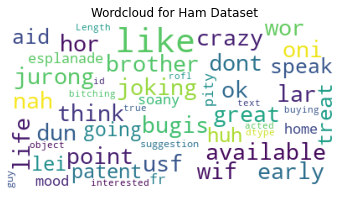

In [8]:
# Let's create different dataframes for both the categories
ham_df = df[df['category'] == 'ham']
spam_df = df[df['category'] == 'spam']

# Create a wordcloud for the above dataframes
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=STOP_WORDS,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(ham_df['text']))


fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Wordcloud for Ham Dataset')

plt.show()

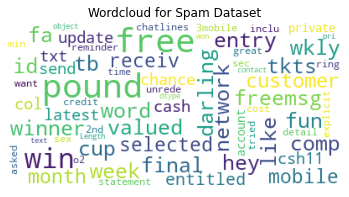

In [9]:
# Create a wordcloud for the above dataframes
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=STOP_WORDS,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(spam_df['text']))


fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Wordcloud for Spam Dataset')

plt.show()

we can see the most frequent words occurring the spam and ham dataset

In [10]:
# Let's look at the statistics in terms of the category
df.groupby('category').describe().reset_index()

category  text                                                            \
           count unique                                                top   
0      ham  4464   4464                        ya telling abt tht incident   
1     spam   629    629  07732584351 rodger burn msg tried reply sm fre...   

        
  freq  
0    1  
1    1

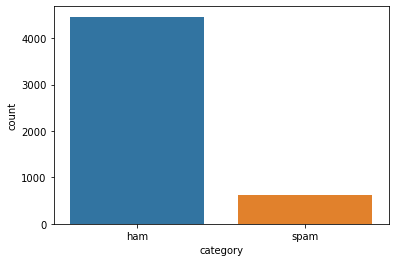

In [11]:
sns.countplot(df.category)

###### Looks like we have a highly unbalanced dataset

For highly unbalanced datasets we ususally apply any three procedures:
1. Undersampling: We reduce the number of datapoints of the dominant category equal to the number of the smaller category
2. Oversampling:
3. Synthetic Minority Oversampling Technique

## Encoding the dataset

In [12]:
# Encoding the category column to binary
df['category'] = df['category'].map({'spam': 1, 'ham': 0})

# split data into train and validation 
train_df, valid_df = train_test_split(df)

def tokenizer(text): # create a tokenizer function
    """ A function for tokenization"""
    return [tok.text for tok in nlp.tokenizer(text)]

TEXT = data.Field(tokenize = tokenizer)
LABEL = data.LabelField(dtype = torch.float)

In [13]:
df.head()

,category,text
0,0,jurong point crazy available bugis n great wor...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun early hor u c
4,0,nah dont think go usf life


In [14]:
TEXT = data.Field(tokenize = tokenizer, include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [15]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.category if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [16]:
# creating torchtext fields
fields = [('text',TEXT), ('category',LABEL)]

# Making tabular datasets
train_ds, val_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df)

# Lets look at a random example
print(vars(train_ds[15]))
# Check the type 
print(type(train_ds[15]))

{'text': ['everybody', 'fun', 'evening', 'miss'], 'category': 0}
<class 'torchtext.data.example.Example'>


## Modelling

In [17]:
# Building vocab for text and categories
MAX_VOCAB_SIZE = 20000

TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.100d',
                 unk_init = torch.Tensor.zero_)

LABEL.build_vocab(train_ds)

In [18]:
# Creating training and validation iterators with batch_sizes 
BATCH_SIZE = 16

train_iter, valid_iter = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [19]:
num_epochs = 25
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

In [20]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        embedded = self.embedding(text)
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)       
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
            
        return output

In [21]:
# creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [22]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

torch.Size([7321, 100])


In [23]:
# Sending the LSTM to GPU
model.to(device) 

# Defining Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch or iterators
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [25]:

def train(model, iterator):
    """
    Training function
    model: The LSTM_net model defined above
    iterator: train and validation iterators with batch sizes
    """
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.category)
        acc = binary_accuracy(predictions, batch.category)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [26]:
def evaluate(model, iterator):
    """
    Function for evaluation of the trained model
    model: The LSTM_net model defined above
    iterator: train and validation iterators with batch sizes
    """
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.category)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)


In [27]:
t = time.time()
loss=[]
acc=[]
val_acc=[]

# Running the model and logging the results
for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iter)
    valid_acc = evaluate(model, valid_iter)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.339 | Train Acc: 91.82%
	 Val. Acc: 96.08%
	Train Loss: 0.186 | Train Acc: 96.05%
	 Val. Acc: 95.56%
	Train Loss: 0.162 | Train Acc: 97.37%
	 Val. Acc: 96.08%
	Train Loss: 0.178 | Train Acc: 96.34%
	 Val. Acc: 95.17%
	Train Loss: 0.160 | Train Acc: 96.94%
	 Val. Acc: 92.36%
	Train Loss: 0.146 | Train Acc: 97.12%
	 Val. Acc: 96.86%
	Train Loss: 0.151 | Train Acc: 97.23%
	 Val. Acc: 96.94%
	Train Loss: 0.134 | Train Acc: 97.46%
	 Val. Acc: 97.09%
	Train Loss: 0.144 | Train Acc: 97.20%
	 Val. Acc: 96.86%
	Train Loss: 0.141 | Train Acc: 97.54%
	 Val. Acc: 96.94%
	Train Loss: 0.139 | Train Acc: 97.47%
	 Val. Acc: 97.09%
	Train Loss: 0.132 | Train Acc: 97.59%
	 Val. Acc: 97.02%
	Train Loss: 0.140 | Train Acc: 97.86%
	 Val. Acc: 97.09%
	Train Loss: 0.135 | Train Acc: 97.71%
	 Val. Acc: 97.09%
	Train Loss: 0.137 | Train Acc: 97.70%
	 Val. Acc: 97.09%
	Train Loss: 0.137 | Train Acc: 97.80%
	 Val. Acc: 96.86%
	Train Loss: 0.141 | Train Acc: 97.57%
	 Val. Acc: 96.94%
	Train Loss: 0

## Hyperparameter tuning using Gaussian optimization
### Building a structured system with the help of ignite library

In [28]:
# # Defining configuration wrapped in hyperopt
# model_space = {
#     'hidden_dim': hp.quniform('hidden_dim', 200, 400, 56),
#     'n_layers': hp.choice('n_layers', range(1, 5)),
#     'bidirectional': hp.choice('bidirectional', [True, False]),
#     'dropout': hp.uniform('dropout', 0, 1),

# }

# hyperopt.pyll.stochastic.sample(model_space)

In [29]:
# def objective(params):
#     """ 
#     Defining a function to be optimised by hyperopt
#     """
    
#     hidden_dim = int(params['hidden_dim'])
#     n_layers = int(params['n_layers'])
#     bidirectional = params['bidirectional']
#     dropout = params['dropout']
    
#     # Defining the values of hyper-parameters which do not need tuning
#     num_epochs = 25
#     learning_rate = 0.001
#     weight_decay = 1e-5
#     vocab_size = len(TEXT.vocab)
#     embedding_dim = 100
#     output_dim = 1
#     PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding
    
#     #creating instance of our LSTM_net class
#     model = LSTM_net(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
#                  bidirectional, dropout, PAD_IDX, pretrained_embeddings)
        
#     # Defining loss function and the optimizer
#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay, lr=learning_rate)
    
#     # Putting the model on GPU
#     model.to(device)
#     criterion.to(device)
    
#     # Switching to ignite library
#     def process_function(engine, batch):
        
#         model.train()
#         optimizer.zero_grad()
#         x, text_length = batch.text
#         y = batch.category
# #         x.to(device)
# #         y.to(device)
#         y_pred = model(x)
#         y_pred = y_pred.squeeze()
#         loss = criterion(y_pred, y)
#         loss.backward()
#         optimizer.step()
#         return loss.item()
    
#     def eval_function(engine, batch):
#         model.eval()
#         with torch.no_grad():
#             x, text_length = batch.text
#             y = batch.category
#             y_pred = model(x)
#             y_pred = y_pred.squeeze()
#   
#             return y_pred, y
        
#     # Loading Engines for train and validation datasets
#     trainer = Engine(process_function)
#     train_evaluator = Engine(eval_function)
#     validation_evaluator = Engine(eval_function)
    
    
#     def thresholded_output_transforms(output):
#         y_pred, y = output
# #         y_pred = y_pred.squeeze()

#         y_pred = torch.round(y_pred)
#         return y_pred, y
    
#     # Defining evaluation metrices for evaluation
#     accuracy = Accuracy(output_transform=thresholded_output_transforms)
#     precision = Precision(output_transform=thresholded_output_transforms, average=True)
#     recall = Recall(output_transform=thresholded_output_transforms, average=True)
    
#     # Attaching the defined metrics to engine
#     accuracy.attach(train_evaluator, 'accuracy')
#     precision.attach(train_evaluator, 'precision')
#     recall.attach(train_evaluator, 'recall')
    
#     accuracy.attach(validation_evaluator, 'accuracy')
#     precision.attach(validation_evaluator, 'precision')
#     recall.attach(validation_evaluator, 'recall')
    
#     # Creating a progress bar to show training
#     pbar = ProgressBar(persist=True, bar_format="")
#     pbar.attach(trainer, ['loss'])
    
#     def score_function(engine):
#         val_loss = engine.state.metrics['nll']
#         return -val_loss
    
#     handler = EarlyStopping(patience=15, score_function=score_function, trainer=trainer)
#     validation_evaluator.add_event_handler(Events.COMPLETED, handler)
    
    
#     @trainer.on(Events.EPOCH_COMPLETED)
#     def log_training_results(engine):
        
#         train_evaluator.run(train_iter)
#         metrics = train_evaluator.state.metrics
#         avg_accuracy = metrics['accuracy']
#         avg_loss = metrics['nll']
#         recall = metrics['recall']
#         precision = metrics['precision']
#         confusion_matrix = metrics['confusion_matrix']
#         pbar.log_message(
#         "Training Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}"
#         .format(engine.state.epoch, avg_accuracy, avg_loss))
        

#     @trainer.on(Events.EPOCH_COMPLETED)
#     def log_validation_results(engine):
        
#         train_evaluator.run(train_iter)
#         metrics = train_evaluator.state.metrics
#         avg_accuracy = metrics['accuracy']
#         avg_loss = metrics['nll']
#         recall = metrics['recall']
#         precision = metrics['precision']
#         confusion_matrix = metrics['confusion_matrix']
#         pbar.log_message(
#         "Validation Results - Epoch: {} Avg accuracy: {:.2f} Avg loss: {:.2f}"
#         .format(engine.state.epoch, avg_accuracy, avg_loss))
#         pbar.n = pbar.last_print_n = 0
        
#     trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)
    
#     def get_final_loss():
            
#         validation_evaluator.run(val_iter)
#         metrics = validation_evaluator.state.metrics
#         avg_loss = metrics['accuracy']
#         return avg_loss
    
#     trainer.run(train_iter, max_epochs=5)
 
#     return {'loss': get_final_loss(),
#            'model': model.state_dict(),
#            'status': STATUS_OK}

In [30]:
# if __name__ == '__main__':
    
#     trials = Trials()
#     best = fmin(objective, space=model_space, algo=tpe.suggest, max_evals=2, trials=trials)
#     trained_model = trials.best_trial['result']['model']
#     best_parameters = space_eval(model_space, best)
    
#     torch.save({'model_state_dict': trained_model,
#               'model_config': best_parameters}
#               )